In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import os
import random


from empirical_data import *
from optimized_random_response import *
from randomized_response import *
from repetitive_optimizer import *
from synthetic_dataset import *
from exponential_mechanism import *
from simpleinfotheory import *
from normalize_error_matrix import *
from alphabet import *
import matplotlib as mpl
import matplotlib.lines as mlines

mpl.rcParams.update({'font.size': 12})

In [44]:
def mutual_info_pair(a, b):
    return mutualinformationempirical(xn=a, yn=b)[0]

In [45]:
# I(A;A',B') = I(A;A') + I(A;B'|A')

def conditional_mutual_info(a, b, c):
    return conditionalmutualinformationempirical(a, b, c)

def total_info_leakage(A, A_prime, B_prime):
    return mutual_info_pair(A, A_prime) + conditional_mutual_info(A, B_prime, A_prime)

In [46]:
def mutual_information(a, b):
    processed_a = []
    # print(a)
    # print(b)
    for i in a:
        actual_split = i.split(" ")
        actual = []
        # print(actual_split)
        for j in actual_split:
            # print(i)
            if j != "" :
                actual.append(int(j))
        processed_a.append(np.array(actual))
    processed_a = np.array(processed_a)
    processed_b = []
    
    for i in b:
        actual_split = i.split(" ")
        actual = []
        # print(actual_split)
        for j in actual_split:
            # print(i)
            if j != "" :
                actual.append(int(j))
        processed_b.append(np.array(actual))
    processed_b = np.array(processed_b)

    mi = []
    # print("processed_a", processed_a)
    # print("processed_b", processed_b)
    # for i in range(np.shape(processed_b)[1]):
    #     mi.append(mutual_info_pair(processed_a[:,i], processed_b[:,i]))
    # mi.append(mutual_info_pair(processed_a[:,0], processed_a[:,1]))
    # mi.append(mutual_info_pair(processed_b[:,1], processed_b[:,0]))
    # mi.append(mutual_info_pair(processed_a[:,0], processed_b[:,0]))
    # mi.append(mutual_info_pair(processed_a[:,1], processed_b[:,1]))
    mi.append(total_info_leakage(processed_a[:,0], processed_b[:,0], processed_b[:,1]))
    mi.append(total_info_leakage(processed_a[:,1], processed_b[:,1], processed_b[:,0]))
    # mi.append(total_info_leakage(processed_a[:,0], processed_b[:,1], processed_b[:,0]))
    return mi
    

2.0
l2_error  1.1291043272357575
2.1
l2_error  1.2096101674984936
2.2
l2_error  1.3191292484697241
2.3000000000000003
l2_error  1.4116685474205033
2.4000000000000004
l2_error  1.493870871449399
2.0
l2_error  1.1291043272357575
2.1
l2_error  1.2096101674984936
2.2
l2_error  1.3191292484697241
2.3000000000000003
l2_error  1.4116685474205033
2.4000000000000004
l2_error  1.493870871449399
2.0
l2_error  1.1451390865329854
2.1
l2_error  1.2319600976776819
2.2
l2_error  1.3150525412336895
2.3000000000000003
l2_error  1.408913572525731
2.4000000000000004
l2_error  1.4967228010935913
2.5
l2_error  1.589283225740615
2.6
l2_error  1.6527089847013554
2.7
l2_error  1.7241536875564136
2.8000000000000003
l2_error  1.8591837894719805
2.9000000000000004
l2_error  1.8178243334571427
3.0
l2_error  1.9279147814204922
3.1
l2_error  2.028977028569292
3.2
l2_error  2.029000013413775
3.3000000000000003
l2_error  2.174142038241356
3.4000000000000004
l2_error  2.1126478511550424
3.5
l2_error  2.1512832202145864

<Figure size 640x480 with 0 Axes>

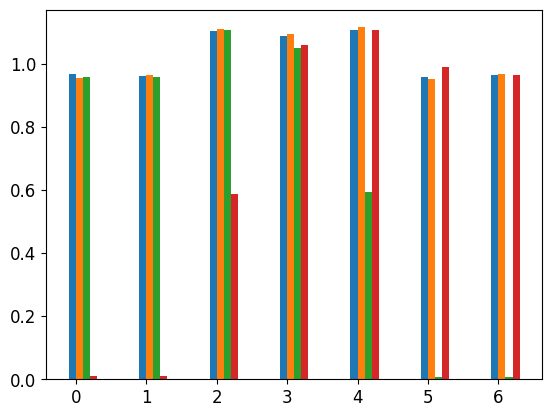

In [47]:
'''
    Test information leakage of attributes against their weight ratio.
'''

TARGET_UTILITY_ERROR = 0.15
NUM_ATTRIBUTES = 2
NUM_STATES = [6, 6]
DATASET_SIZE = 15000
EPS_ARRAY = np.arange(20, 70)*0.10
plt.tight_layout()

# priority_list = [{'1': 0.01*2/1.01, '0': 1*2/1.01}, {'1': 0.1*2/1.1, '0': 1*2/1.1}, {'1': 0.5*2/1.5, '0': 1*2/1.5}, {'1': 1, '0': 1}, {'1': 1*2/1.5, '0': 0.5*2/1.5}, {'1': 1*2/1.1, '0': 0.1*2/1.1}, {'1': 1*2/1.01, '0': 0.01*2/1.01}]
priority_list = [{'1': 0.01, '0': 1}, {'1': 0.1, '0': 1}, {'1': 0.5, '0': 1}, {'1': 1, '0': 1}, {'1': 1, '0': 0.5}, {'1': 1, '0': 0.1}, {'1': 1, '0': 0.01}]
# priority_list = [{'1': 100, '0': 1}, {'1': 50, '0': 1}, {'1': 20, '0': 1}, {'1': 1, '0': 1}] 
distribution_list = np.ones(36)/36 # [0.3, 0.01, 0.01, 0.01, 0.30, 0.01, 0.01, 0.01, 0.34]

colour_err_ = {"k-RR": "red", "Optimal k-RR": "blue"}
colour_mi_ = {"k-RR": ["lightsalmon", "brown"], "Optimal k-RR": ["green", "purple"]}

values_k_rr = []
values_optimal = []

for priority_dict in priority_list:
    random_dist = distribution_list
    TOTAL_STATES = 1
    alphabet_dict = {}
    for i in range(NUM_ATTRIBUTES):
        TOTAL_STATES *= NUM_STATES[i]
        alphabet_dict[str(i)] = np.arange(NUM_STATES[i])

    ALL_ALPHABET = create_alphabet(attributes_with_alphabet=alphabet_dict)
    STRING_ALL_ALPHABET = convert_alphabet_to_string(ALL_ALPHABET)
    ATTRIBUTE_LIST = list(alphabet_dict.keys())

    synthetic_dataset_constructor = Gen_Synthetic_Dataset(no_of_states = TOTAL_STATES, no_of_samples = DATASET_SIZE, alphabet=STRING_ALL_ALPHABET)
    correlated_synthetic_dataset = synthetic_dataset_constructor.gen_custom(distribution=random_dist)

    alphabet_dict = {}
    for i in range(len(ALL_ALPHABET)):
        alphabet_dict[str(ALL_ALPHABET[i])] = i
    normalize_error_matrix = Normalize_error_matrix(attribute_list=ATTRIBUTE_LIST, alphabet=ALL_ALPHABET, priority_dict=priority_dict, alphabet_dict=alphabet_dict)
    err_matrix = normalize_error_matrix.normalized_error_matrix
    # sns.heatmap(err_matrix)
    # plt.show()
    random_response_mechanism = Randomized_Response(STATE_COUNT=TOTAL_STATES, INPUT_ALPHABET=STRING_ALL_ALPHABET, normalized_objective_err_matrix=err_matrix)

    optimal_random_response_mechanism = Optimized_Randomized_Response(prior_dist = random_dist, STATE_COUNT = TOTAL_STATES, INPUT_ALPHABET = STRING_ALL_ALPHABET, normalized_objective_err_matrix = err_matrix, 
                        TOLERANCE_MARGIN = 0.01, APPROXIMATION = "LINEAR", solver = "SCS", is_kl_div = True, ALPHA=0.01, accelerate_from_rr=True)

    mechanisms_dict = {"k-RR": random_response_mechanism, "Optimal k-RR": optimal_random_response_mechanism}

    error_dict = {}
    mi_dict = {}

    for key in list(mechanisms_dict.keys()):
        error_dict[key] = []
        mi_dict[key] = []

    for mechanism in list(mechanisms_dict.keys()):
        for eps in EPS_ARRAY:
        
            __tot_error = 0
            __perturbed_value_list = []
            for entry in correlated_synthetic_dataset:
                __perturbed_value_list.append(mechanisms_dict[mechanism].gen_random_output(actual_value=entry, eps=eps)[0])

                __error = normalize_error_matrix.get_value_error(actual=entry, perturbed=__perturbed_value_list[-1])
                __tot_error += __error
            
            error_dict[mechanism].append(__tot_error/len(correlated_synthetic_dataset))

            if error_dict[mechanism][-1] < TARGET_UTILITY_ERROR:
                mi_dict[mechanism].append(mutual_information(correlated_synthetic_dataset, __perturbed_value_list))
                break

    values_k_rr.append(mi_dict["k-RR"][0])
    values_optimal.append(mi_dict["Optimal k-RR"][0])

values_k_rr = np.array(values_k_rr)
values_optimal = np.array(values_optimal)

x = np.arange(len(priority_list))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values_k_rr[:, 0], width, label='Feature 1')
rects2 = ax.bar(x + width/2, values_k_rr[:, 1], width, label='Feature 2')
rects2 = ax.bar(x + width + width/2, values_optimal[:, 0], width, label='Feature 2')
rects2 = ax.bar(x + width*2 + width/2, values_optimal[:, 1], width, label='Feature 2')
plt.show()



2
l2_error  0.01598715691505046
2
l2_error  0.8304660073366418
2
l2_error  1.0048645582688458
2
l2_error  1.1222201996216763
2
l2_error  1.0632243431360868
2
l2_error  1.0321302123062746
2
l2_error  1.054575843584656
2
l2_error  0.8090617207412326
2
l2_error  0.8967133883124959
2
l2_error  0.9495193467095984
mechanism  [0.29974117082527557, 0.3035038689675102, 0.30315814362660654, 0.2998687024512631, 0.30944356701116515, 0.32483702077909893, 0.30559738102601575, 0.2879857625081722, 0.3124521353989886, 0.3131693270698262]
mechanism  [0.30517566360663834, 0.2680460864383777, 0.281127257708508, 0.26208978356374973, 0.27134343020890334, 0.28490132414071684, 0.25434928414733865, 0.26511222383433614, 0.29846462675019947, 0.26789803245606914]
2
l2_error  1.2522938531284116
2
l2_error  1.0710564212674818
2
l2_error  1.0537350979144249
2
l2_error  0.9528110856697706
2
l2_error  1.2144265168583501
2
l2_error  1.064609090234155
2
l2_error  1.1186888464023914
2
l2_error  1.18081534608896
2
l2_erro

<Figure size 640x480 with 0 Axes>

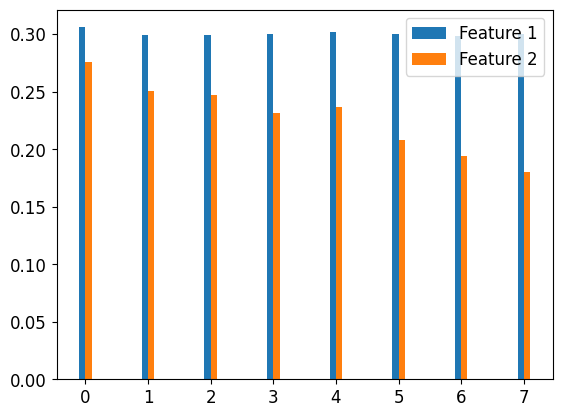

In [48]:
'''
    Test information leakage of attributes against different corrlations
'''

TARGET_UTILITY_ERROR = 0.2
NUM_ATTRIBUTES = 2
NUM_STATES = [3, 3]
DATASET_SIZE = 10000
EPS_ARRAY = np.arange(40)*0.16
plt.tight_layout()

priority_list = [{'1': 0.01, '0': 1}, {'1': 0.1, '0': 1}, {'1': 0.5, '0': 1}, {'1': 1, '0': 1}, {'1': 1, '0': 0.5}, {'1': 1, '0': 0.1}, {'1': 1, '0': 0.01}]
# priority_list = [{'1': 100, '0': 1}, {'1': 50, '0': 1}, {'1': 20, '0': 1}, {'1': 1, '0': 1}] 
# distribution_list = [0.3, 0.01, 0.01, 0.01, 0.30, 0.01, 0.01, 0.01, 0.34]

synthetic_dist = Gen_Synthetic_Distribution(original_dist=np.ones(9)/9, no_samples=20, sample_count_per_sample=100, div_type = "MI", attribute_state_count=NUM_STATES)
synthetic_dist.create_distribution()
synthetic_distribution_dict = synthetic_dist.get_synthetic_distribution()
distribution_list = list(synthetic_distribution_dict.values())

colour_err_ = {"k-RR": "red", "Optimal k-RR": "blue"}
colour_mi_ = {"k-RR": ["lightsalmon", "brown"], "Optimal k-RR": ["green", "purple"]}

values_k_rr = []
values_optimal = []

for random_dist_list in distribution_list:
    if len(random_dist_list) == 0:
        continue
    error_dict = {}
    mi_dict = {}

    for key in list(mechanisms_dict.keys()):
        error_dict[key] = []
        mi_dict[key] = []
    for random_dist in random_dist_list[:min(10,len(random_dist_list))]:
        priority_dict =  {'1': 1, '0': 1}
        TOTAL_STATES = 1
        alphabet_dict = {}
        for i in range(NUM_ATTRIBUTES):
            TOTAL_STATES *= NUM_STATES[i]
            alphabet_dict[str(i)] = np.arange(NUM_STATES[i])

        ALL_ALPHABET = create_alphabet(attributes_with_alphabet=alphabet_dict)
        STRING_ALL_ALPHABET = convert_alphabet_to_string(ALL_ALPHABET)
        ATTRIBUTE_LIST = list(alphabet_dict.keys())

        synthetic_dataset_constructor = Gen_Synthetic_Dataset(no_of_states = TOTAL_STATES, no_of_samples = DATASET_SIZE, alphabet=STRING_ALL_ALPHABET)
        correlated_synthetic_dataset = synthetic_dataset_constructor.gen_custom(distribution=random_dist)

        alphabet_dict = {}
        for i in range(len(ALL_ALPHABET)):
            alphabet_dict[str(ALL_ALPHABET[i])] = i
        normalize_error_matrix = Normalize_error_matrix(attribute_list=ATTRIBUTE_LIST, alphabet=ALL_ALPHABET, priority_dict=priority_dict, alphabet_dict=alphabet_dict)
        err_matrix = normalize_error_matrix.normalized_error_matrix
        # sns.heatmap(err_matrix)
        # plt.show()
        random_response_mechanism = Randomized_Response(STATE_COUNT=TOTAL_STATES, INPUT_ALPHABET=STRING_ALL_ALPHABET, normalized_objective_err_matrix=err_matrix)
        # random_response_mechanism = Exponential_mechanism(prior_dist=random_dist, STATE_COUNT=TOTAL_STATES, INPUT_ALPHABET=STRING_ALL_ALPHABET, normalized_objective_err_matrix=err_matrix, only_err_matrix=True)
        optimal_random_response_mechanism = Optimized_Randomized_Response(prior_dist = random_dist, STATE_COUNT = TOTAL_STATES, INPUT_ALPHABET = STRING_ALL_ALPHABET, normalized_objective_err_matrix = err_matrix, 
                            TOLERANCE_MARGIN = 0.01, APPROXIMATION = "LINEAR", solver = "SCS", is_kl_div = True, ALPHA=0.01, accelerate_from_rr=True)

        mechanisms_dict = {"k-RR": random_response_mechanism, "Optimal k-RR": optimal_random_response_mechanism}

        

        for mechanism in list(mechanisms_dict.keys()):
            for eps in [2]: # EPS_ARRAY:
            
                __tot_error = 0
                __perturbed_value_list = []
                for entry in correlated_synthetic_dataset:
                    __perturbed_value_list.append(mechanisms_dict[mechanism].gen_random_output(actual_value=entry, eps=eps)[0])

                    __error = normalize_error_matrix.get_value_error(actual=entry, perturbed=__perturbed_value_list[-1])
                    __tot_error += __error
                
                error_dict[mechanism].append(__tot_error/len(correlated_synthetic_dataset))
    for mechanism in list(mechanisms_dict.keys()):
        print("mechanism ",error_dict[mechanism])
        error_dict[mechanism] = sum(error_dict[mechanism])/len(error_dict[mechanism])
    values_k_rr.append(error_dict["k-RR"])
    values_optimal.append(error_dict["Optimal k-RR"])

# values_k_rr = np.array(values_k_rr)
# values_optimal = np.array(values_optimal)

x = np.arange(len(values_k_rr))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values_k_rr, width, label='Feature 1')
rects2 = ax.bar(x + width/2, values_optimal, width, label='Feature 2')
plt.legend()
plt.show()



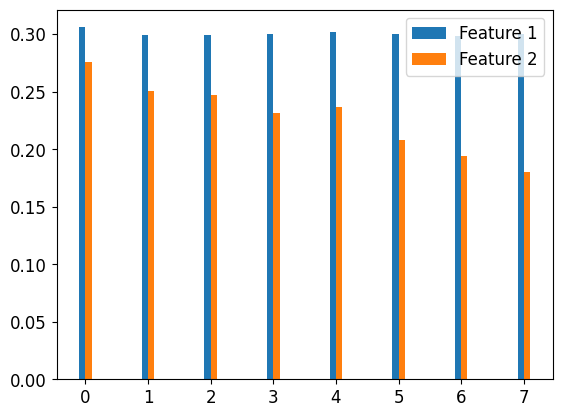

In [49]:
x = np.arange(len(values_k_rr))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values_k_rr, width, label='Feature 1')
rects2 = ax.bar(x + width/2, values_optimal, width, label='Feature 2')
plt.legend()
plt.show()